In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [0]:
#normaliza o dataset usando um pouco de data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#normaliza o dataset de test mas sem data augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
#dataset de treino com batch de tamanho 32 e de teste com tamanho 4
train_loader = DataLoader(dataset=dataset_train, shuffle=True,batch_size =32)
test_loader = DataLoader(dataset=dataset_test, shuffle=False,batch_size =4 )

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


torch.Size([32, 3, 32, 32])
cuda:0


In [0]:

#definindo a Rede
class CNN(nn.Module):
  
  def __init__(self):
    super(CNN, self).__init__()

    self.conv_layer = nn.Sequential(
            
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
              
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),
            
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
            )

    self.fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(4096, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
        )


  def forward(self, x):  

    x = self.conv_layer(x)      
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x
  

#DEFININDO O TREINO

In [0]:
# TREINO
def train(epoch,train_acc,train_losses):
  print('\nEpoca: %d' % epoch)
  net.train()
  train_loss = []
  correct = 0
  total = 0
  accuracy = 0
  
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  accuracy = 100*correct/total
  train_losses.append(np.mean(train_loss))
  train_acc.append(accuracy)
  print(' train_loss : {:.4f} , train_ acc : {:.2f}%'\
            .format(np.mean(train_loss),accuracy))
      

#DEFININDO A VALIDAÇÃO 

In [0]:
#TESTE
def test(epoch,test_acc,test_losses):
  global best_acc
  net.eval()
  test_loss = 0
  correct = 0
  total = 0
  accuracy =0
  test_loss = []
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, targets)

      #test_loss += loss.item()
      test_loss.append(loss.item())
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
    accuracy = 100*correct/total
    test_acc.append(accuracy)
    test_losses.append(np.mean(test_loss))
    print(' test_loss : {:.4f} , test_ acc : {:.2f}%'\
            .format(np.mean(test_loss),accuracy))

#CONSTRUINDO O MODELOM, SETANDO A LOSS E OPTIMIZER

In [0]:

# Constroi o modelo
print('==> Building model..')
net = CNN()
net = net.to(device)


#define a loss e o otimizador. SGD foi testado, mas não trouxe bons resultados
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

==> Building model..


#TREINADO DURANTE 100 EPOCAS


In [64]:


train_acc_net1 = []
train_losses_net1 = []
test_acc_net1 = []
test_losses_net1 = []

epochs =100


for epoch in range(epochs):
  train(epoch,train_acc = train_acc_net1,train_losses = train_losses_net1)
  test(epoch,test_acc = test_acc_net1,test_losses = test_losses_net1)


Epoca: 0
 train_loss : 1.5942 , train_ acc : 40.12%
 test_loss : 1.3255 , test_ acc : 51.21%

Epoca: 1
 train_loss : 1.2284 , train_ acc : 55.41%
 test_loss : 1.1842 , test_ acc : 58.61%

Epoca: 2
 train_loss : 1.0475 , train_ acc : 62.70%
 test_loss : 0.8934 , test_ acc : 68.24%

Epoca: 3
 train_loss : 0.9217 , train_ acc : 67.42%
 test_loss : 0.7733 , test_ acc : 72.92%

Epoca: 4
 train_loss : 0.8275 , train_ acc : 71.16%
 test_loss : 0.7989 , test_ acc : 72.18%

Epoca: 5
 train_loss : 0.7591 , train_ acc : 73.74%
 test_loss : 0.6671 , test_ acc : 77.10%

Epoca: 6
 train_loss : 0.7021 , train_ acc : 75.77%
 test_loss : 0.6059 , test_ acc : 79.19%

Epoca: 7
 train_loss : 0.6578 , train_ acc : 77.28%
 test_loss : 0.6197 , test_ acc : 79.03%

Epoca: 8
 train_loss : 0.6229 , train_ acc : 78.81%
 test_loss : 0.5732 , test_ acc : 80.36%

Epoca: 9
 train_loss : 0.5867 , train_ acc : 79.95%
 test_loss : 0.6071 , test_ acc : 79.56%

Epoca: 10
 train_loss : 0.5628 , train_ acc : 80.82%
 test_

#GRAFICO DO LOSS

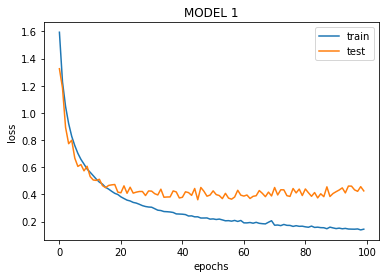

In [65]:
plt.title("MODEL 1")
x = np.arange(0,epochs)
plt.plot(x,train_losses_net1,label = "train")
plt.plot(x,test_losses_net1,label = "test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#GRAFICO DA ACURÁCIA




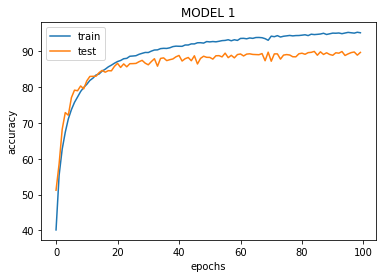

In [66]:
plt.title("MODEL 1")
x = np.arange(0,epochs)
plt.plot(x,train_acc_net1,label = "train")
plt.plot(x,test_acc_net1,label = "test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()